
This notebook is built for designing the cdss tool for identifying low-risk patients.

Key steps:
- Prepare input and output data
- CDSS
  - Stage 1: Training-validation
  - Stage 2: Testing

Output:
- Clinician-friendly decision table

In [ ]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

In [ ]:
# ==============================
# 1. Prepare Data
# ==============================

In [ ]:
data_reg = pd.read_pickle('04_analyzed_data.pkl')
test_data = pd.read_pickle('04_analyzed_data.pkl')

In [ ]:
inputs_reg = data_reg.drop(columns=['DFI','TUNEL'])
test_inputs_reg = test_data.drop(columns=['DFI','TUNEL'])

# Identify numerical features (float64 and int64)
numerical_input_features_reg = inputs_reg.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_test_input_features = test_inputs_reg.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Identify categorical features (category and bool)
categorical_input_features_reg = inputs_reg.select_dtypes(include=['category', 'bool']).columns.tolist()
categorical_test_input_features_reg = test_inputs_reg.select_dtypes(include=['category', 'bool']).columns.tolist()


# Targets
targets = ['DFI','TUNEL']

In [ ]:
X_scaled_reg = pd.DataFrame(
    RobustScaler().fit_transform(data_reg[numerical_input_features_reg]),
    columns=numerical_input_features_reg,
    index=data_reg.index
)

X_test_scaled_reg = pd.DataFrame(
    RobustScaler().fit_transform(test_data[numerical_test_input_features]),
    columns=numerical_test_input_features,
    index=test_data.index
)

In [ ]:
X_cat = pd.get_dummies(data_reg[categorical_input_features_reg], drop_first=True)
X_test_cat = pd.get_dummies(test_data[categorical_input_features_reg], drop_first=True)

In [ ]:
#concatanate X_cat and X_scaled in data frame X
X_reg = pd.concat([X_scaled_reg, X_cat], axis=1)
X_test_reg = pd.concat([X_test_scaled_reg, X_test_cat], axis=1)

In [ ]:
y_reg = data_reg[targets]
y_test_reg = test_data[targets]

In [ ]:
# ======================================
# 2. CDSS : Training-validation
# ======================================

In [ ]:
# -------------------------
# QUANTILE MODEL FUNCTION
# -------------------------
def train_quantile_models(X, y, quantiles=[0.05, 0.5, 0.95], n_splits=10, seed=42):
    models = {q: {} for q in quantiles}
    predictions = {q: pd.DataFrame(index=X.index, columns=y.columns) for q in quantiles}
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    for q in quantiles:
        for target in y.columns:
            model = GradientBoostingRegressor(
                loss="quantile", alpha=q, n_estimators=500, learning_rate=0.03,
                max_depth=6, min_samples_leaf=10, subsample=0.7, random_state=seed
            )
            model.fit(X, y[target])
            models[q][target] = model
            predictions[q][target] = cross_val_predict(model, X, y[target], cv=kf, n_jobs=-1)

    return models, predictions


# -------------------------
# EVALUATION FUNCTION
# -------------------------
def evaluate_prediction_intervals(y_true, predictions, quantiles=[0.05, 0.95]):
    """
    Evaluate quantile prediction intervals using metrics like:
    MCP, Interval Width, Sharpness, PINAW, and PINRW.

    Parameters:
        y_true (pd.DataFrame): True target values (each column is a target).
        predictions (dict): Dictionary with keys as quantiles (e.g., 0.05, 0.95),
                            values as DataFrames of predicted quantiles (columns match y_true).
        quantiles (list): Lower and upper quantiles used for interval predictions.

    Returns:
        pd.DataFrame: Evaluation metrics for each target variable.
    """
    q_low, q_high = quantiles
    results = {}

    for col in y_true.columns:
        y = y_true[col]
        y_pred_lower = predictions[q_low][col].reindex(y.index)
        y_pred_upper = predictions[q_high][col].reindex(y.index)

        # Align Series explicitly
        y, y_pred_lower = y.align(y_pred_lower)
        y, y_pred_upper = y.align(y_pred_upper)

        mcp = np.mean((y >= y_pred_lower) & (y <= y_pred_upper))
        interval_width = np.mean(y_pred_upper - y_pred_lower)
        sharpness = interval_width
        range_y = np.max(y) - np.min(y)
        pinaw = np.mean((y_pred_upper - y_pred_lower) / range_y)
        pinrw = np.sqrt(np.mean(((y_pred_upper - y_pred_lower) / range_y) ** 2))

        results[col] = {
            "Mean Coverage Probability": mcp,
            "Interval Width": interval_width,
            "Sharpness": sharpness,
            "PINAW": pinaw,
            "PINRW": pinrw
        }

    return pd.DataFrame(results).T

In [ ]:
models, predictions = train_quantile_models(X_reg, y_reg, quantiles=[0.05, 0.5, 0.95])

# Combine predictions for export or downstream use
y_pred_df = pd.concat(predictions, axis=1)

metrics_df = evaluate_prediction_intervals(y_reg, predictions, quantiles=[0.05, 0.95])

In [ ]:
print(metrics_df.round(4))

       Mean Coverage Probability  Interval Width  Sharpness   PINAW   PINRW
DFI                       0.8457         18.7682    18.7682  0.2720  0.2780
TUNEL                     0.8437         13.5009    13.5009  0.2288  0.2422


In [ ]:
# -------------------------
# SAVE ARTIFACTS
# -------------------------
save_path = Path('saved_models')
save_path.mkdir(exist_ok=True)

with open(save_path / 'quantile_models.pkl', 'wb') as f:
    pickle.dump({
        'models': models,
        'predictions': predictions,
        'metrics': metrics_df,
        'feature_names': X_reg.columns.tolist(),
        'target_names': y_reg.columns.tolist(),
        'quantiles': [0.05,0.5,0.95]
    }, f)

print(f"Saved models and outputs to {save_path / 'quantile_models.pkl'}")

Saved models and outputs to saved_models/quantile_models.pkl


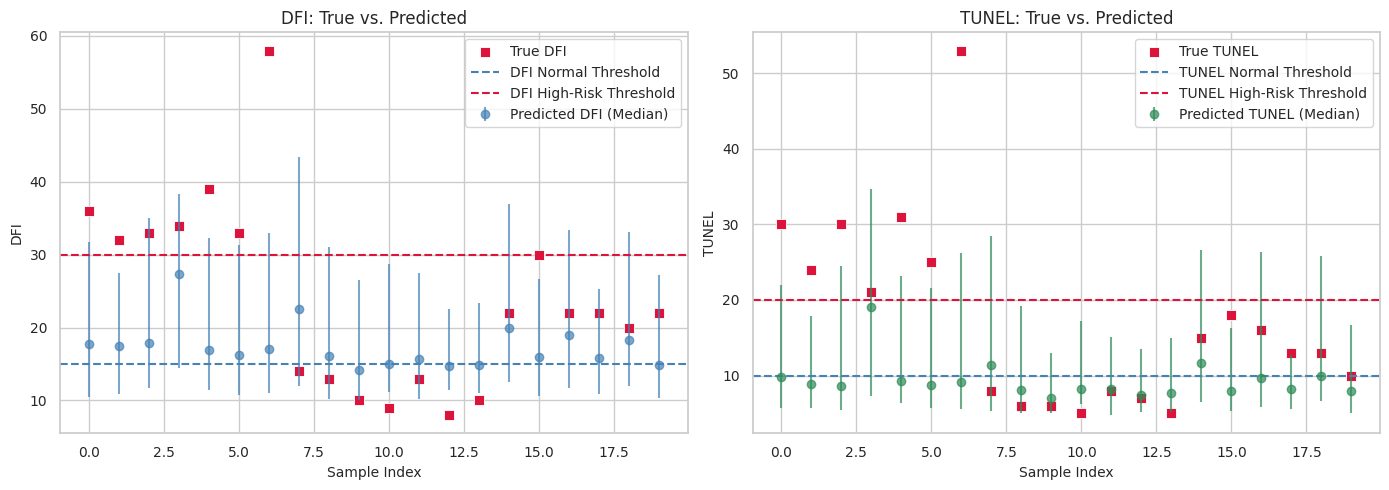

In [ ]:
# -----------------------------
# Select Representative Samples
# -----------------------------
# Set a random seed for reproducibility
np.random.seed(42)

# Filter groups based on conditions
group_1 = X_reg[(data_reg["TUNEL"] >= 20) & (data_reg["DFI"] >= 30)]
group_2 = X_reg[(data_reg["TUNEL"] < 10) & (data_reg["DFI"] < 15)]
group_3 = X_reg[(data_reg["TUNEL"].between(10, 20)) & (data_reg["DFI"].between(15, 30))]

# Sample from each group (assuming enough samples exist in each category)
sample_1 = group_1.sample(n=7, random_state=42, replace=False)
sample_2 = group_2.sample(n=7, random_state=42, replace=False)
sample_3 = group_3.sample(n=6, random_state=42, replace=False)

# Combine samples
random_samples = pd.concat([sample_1, sample_2, sample_3]).index


# -----------------------------
# Prepare DataFrame for Plotting
# -----------------------------

# Extract predictions and true values for selected samples
df_plot = pd.DataFrame({
    "True_DFI": y_reg.loc[random_samples, "DFI"],
    "Predicted_DFI_Median": y_pred_df.loc[random_samples, (0.50, "DFI")],
    "Predicted_DFI_Lower": y_pred_df.loc[random_samples, (0.05, "DFI")],
    "Predicted_DFI_Upper": y_pred_df.loc[random_samples, (0.95, "DFI")],

    "True_TUNEL": y_reg.loc[random_samples, "TUNEL"],
    "Predicted_TUNEL_Median": y_pred_df.loc[random_samples, (0.50, "TUNEL")],
    "Predicted_TUNEL_Lower": y_pred_df.loc[random_samples, (0.05, "TUNEL")],
    "Predicted_TUNEL_Upper": y_pred_df.loc[random_samples, (0.95, "TUNEL")],
}).reset_index(drop=True)


# -----------------------------
# Plot Prediction Intervals
# -----------------------------
# Set Seaborn style with smaller context
sns.set(style="whitegrid", context="notebook")  # 'notebook' uses smaller font sizes

# Optional: Manually control font sizes if needed
SMALL_SIZE = 10
MEDIUM_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

# Melt the DataFrame for seaborn plotting
df_dfi = df_plot[["True_DFI", "Predicted_DFI_Median", "Predicted_DFI_Lower", "Predicted_DFI_Upper"]].copy()
df_tunel = df_plot[["True_TUNEL", "Predicted_TUNEL_Median", "Predicted_TUNEL_Lower", "Predicted_TUNEL_Upper"]].copy()
df_dfi["Index"] = df_tunel["Index"] = df_plot.index

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- DFI ---
axes[0].errorbar(
    df_dfi["Index"], df_dfi["Predicted_DFI_Median"],
    yerr=[
        df_dfi["Predicted_DFI_Median"] - df_dfi["Predicted_DFI_Lower"],
        df_dfi["Predicted_DFI_Upper"] - df_dfi["Predicted_DFI_Median"]
    ],
    fmt='o', color="steelblue", alpha=0.7, label="Predicted DFI (Median)"
)
sns.scatterplot(x="Index", y="True_DFI", data=df_dfi, ax=axes[0], color="crimson", s=60, marker="s", label="True DFI")
axes[0].axhline(15, color="steelblue", linestyle="--", label="DFI Normal Threshold")
axes[0].axhline(30, color="crimson", linestyle="--", label="DFI High-Risk Threshold")
axes[0].set(title="DFI: True vs. Predicted", xlabel="Sample Index", ylabel="DFI")
axes[0].legend()

# --- TUNEL ---
axes[1].errorbar(
    df_tunel["Index"], df_tunel["Predicted_TUNEL_Median"],
    yerr=[
        df_tunel["Predicted_TUNEL_Median"] - df_tunel["Predicted_TUNEL_Lower"],
        df_tunel["Predicted_TUNEL_Upper"] - df_tunel["Predicted_TUNEL_Median"]
    ],
    fmt='o', color="seagreen", alpha=0.7, label="Predicted TUNEL (Median)"
)
sns.scatterplot(x="Index", y="True_TUNEL", data=df_tunel, ax=axes[1], color="crimson", s=60, marker="s", label="True TUNEL")
axes[1].axhline(10, color="steelblue", linestyle="--", label="TUNEL Normal Threshold")
axes[1].axhline(20, color="crimson", linestyle="--", label="TUNEL High-Risk Threshold")
axes[1].set(title="TUNEL: True vs. Predicted", xlabel="Sample Index", ylabel="TUNEL")
axes[1].legend()

# Final layout
plt.tight_layout()
plt.savefig("range_prediction.png", dpi=400, bbox_inches="tight")
plt.show()



--- DFI Risk Classification ---
Accuracy:  61.16%
Precision: 95.45%
Recall:    59.87%

Classification Report:
              precision    recall  f1-score   support

          RT       0.16      0.73      0.27       841
          NT       0.95      0.60      0.74      7875

    accuracy                           0.61      8716
   macro avg       0.56      0.67      0.50      8716
weighted avg       0.88      0.61      0.69      8716


--- TUNEL Risk Classification ---
Accuracy:  69.96%
Precision: 96.18%
Recall:    70.41%

Classification Report:
              precision    recall  f1-score   support

          RT       0.14      0.64      0.24       631
          NT       0.96      0.70      0.81      8085

    accuracy                           0.70      8716
   macro avg       0.55      0.67      0.52      8716
weighted avg       0.90      0.70      0.77      8716



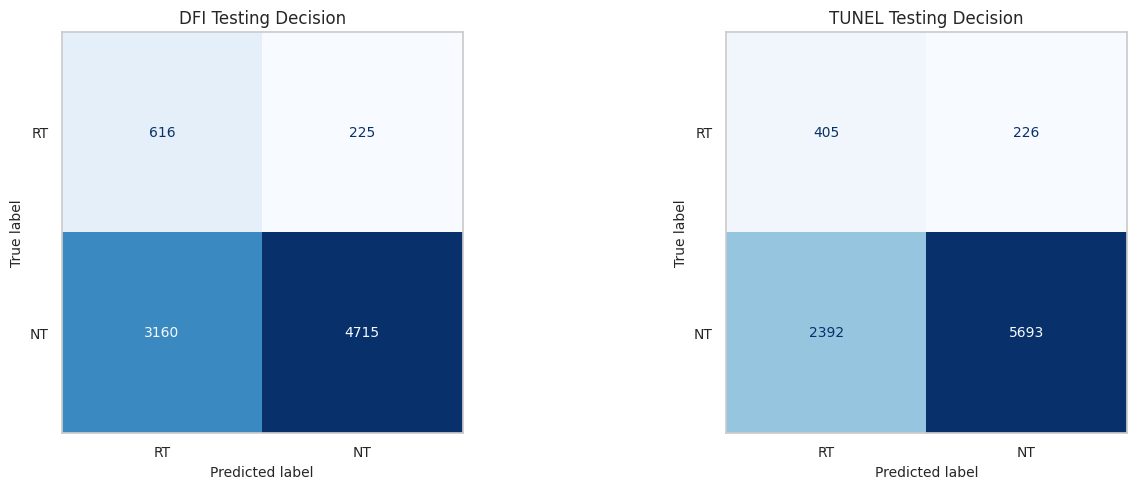

In [ ]:
# --- Define risk thresholds ---
dfi_thresh, tunel_thresh = 30, 20

# --- Create decision DataFrame with upper bounds and assigned risk ---
decision_df = pd.DataFrame({
    "Predicted_DFI_Upper": y_pred_df[(0.95, "DFI")],
    "Predicted_TUNEL_Upper": y_pred_df[(0.95, "TUNEL")]
})

decision_df["DFI_Testing_Decision"] = np.where(decision_df["Predicted_DFI_Upper"] < dfi_thresh, "NT", "RT")
decision_df["TUNEL_Testing_Decision"] = np.where(decision_df["Predicted_TUNEL_Upper"] < tunel_thresh, "NT", "RT")

# --- Define true low-risk patients based on ground truth ---
true_risk_dfi = y_reg["DFI"] < dfi_thresh
true_risk_tunel = y_reg["TUNEL"] < tunel_thresh

# --- Get predicted low-risk flags from decision DataFrame ---
pred_risk_dfi = decision_df["DFI_Testing_Decision"] == "NT"
pred_risk_tunel = decision_df["TUNEL_Testing_Decision"] == "NT"

# --- Define evaluation function ---
def evaluate_risk_prediction(y_true1, y_pred1, label1, y_true2, y_pred2, label2):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for ax, y_true, y_pred, label in zip(axes, [y_true1, y_true2], [y_pred1, y_pred2], [label1, label2]):
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)

        print(f"\n--- {label} Risk Classification ---")
        print(f"Accuracy:  {acc:.2%}")
        print(f"Precision: {prec:.2%}")
        print(f"Recall:    {rec:.2%}")
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=["RT", "NT"]))

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["RT", "NT"])
        disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False)
        ax.set_title(f'{label} Testing Decision')
        ax.grid(False)

    plt.tight_layout()
    plt.savefig("confusion_train_val.png", dpi=400, bbox_inches="tight")
    plt.show()

# --- Call function ---
evaluate_risk_prediction(true_risk_dfi, pred_risk_dfi, "DFI", true_risk_tunel, pred_risk_tunel, "TUNEL")

In [ ]:
# ======================================
# 3. Clinician-friendly Decision Table
# ======================================

In [ ]:
# Attach prediction intervals and risk decisions to data_reg
data_reg["Predicted_DFI_Lower"] = y_pred_df[(0.05, "DFI")]
data_reg["Predicted_DFI_Upper"] = y_pred_df[(0.95, "DFI")]
data_reg["Predicted_TUNEL_Lower"] = y_pred_df[(0.05, "TUNEL")]
data_reg["Predicted_TUNEL_Upper"] = y_pred_df[(0.95, "TUNEL")]
data_reg['DFI_Testing_Decision'] = decision_df['DFI_Testing_Decision']
data_reg['TUNEL_Testing_Decision'] = decision_df['TUNEL_Testing_Decision']

# Define columns for review
decision_table_columns = [
    'DFI', 'TUNEL',
    'Predicted_DFI_Lower', 'Predicted_DFI_Upper',
    'Predicted_TUNEL_Lower', 'Predicted_TUNEL_Upper',
    'DFI_Testing_Decision', 'TUNEL_Testing_Decision'
]
data_reg[decision_table_columns].head(50)

,DFI,TUNEL,Predicted_DFI_Lower,Predicted_DFI_Upper,Predicted_TUNEL_Lower,Predicted_TUNEL_Upper,DFI_Testing_Decision,TUNEL_Testing_Decision
1,14.0,6.0,10.868033,30.419321,5.030896,16.276998,RT,NT
2,35.0,19.0,11.281953,33.241329,5.975352,20.385659,RT,RT
5,12.0,5.0,11.947553,32.038369,5.361212,17.925339,RT,NT
6,15.0,7.0,11.364463,32.779134,5.262648,19.684299,RT,NT
8,15.0,7.0,10.464860,28.177478,4.922485,15.827464,NT,NT
9,14.0,8.0,10.191795,26.945358,4.989900,16.533981,NT,NT
10,18.0,9.0,10.065581,27.534260,4.338947,17.962575,NT,NT
11,9.0,4.0,9.974079,29.558099,5.030624,19.207901,NT,NT
12,13.0,5.0,10.701909,28.183044,5.015030,16.044173,NT,NT
13,15.0,7.0,10.002956,26.885954,5.158245,15.727920,NT,NT


In [ ]:
# ======================================
# 4. CDSS : Testing
# ======================================

In [ ]:
# -------------------------
# LOAD SAVED MODELS
# -------------------------
with open('/content/saved_models/quantile_models.pkl', 'rb') as f:
    data_q = pickle.load(f)

models = data_q['models']
quantiles = data_q['quantiles']
target_names = data_q['target_names']

# -------------------------
# MAKE PREDICTIONS ON Test(NEW) DATA
# -------------------------
def predict_quantiles(models, X_new, quantiles, target_names):
    predictions_new = {q: pd.DataFrame(index=X_new.index, columns=target_names) for q in quantiles}

    for q in quantiles:
        for target in target_names:
            model = models[q][target]
            predictions_new[q][target] = model.predict(X_new)

    return predictions_new

In [ ]:
# Get the correct feature order from the model
model_features = models[quantiles[0]][target_names[0]].feature_names_in_

# Ensure X_new has the exact same feature order
X_test_aligned = X_test_reg[model_features]

# Now make predictions
new_predictions = predict_quantiles(models, X_test_aligned, quantiles, target_names)

# Combine predictions into a single DataFrame (multi-index columns)
y_pred_test_df = pd.concat(new_predictions, axis=1)

In [ ]:
metrics_df = evaluate_prediction_intervals(y_test_reg, new_predictions, quantiles=[0.05, 0.95])
print(metrics_df.round(4))

       Mean Coverage Probability  Interval Width  Sharpness   PINAW   PINRW
DFI                        0.826         19.0068    19.0068  0.3586  0.3672
TUNEL                      0.833         13.9102    13.9102  0.3478  0.3693


In [ ]:
# --- Create decision DataFrame with upper bounds and assigned risk ---
decision_df = pd.DataFrame({
    "Predicted_DFI_Upper": y_pred_test_df[(0.95, "DFI")],
    "Predicted_TUNEL_Upper": y_pred_test_df[(0.95, "TUNEL")]
})

decision_df["DFI_Testing_Decision"] = np.where(decision_df["Predicted_DFI_Upper"] < dfi_thresh, "NT", "RT")
decision_df["TUNEL_Testing_Decision"] = np.where(decision_df["Predicted_TUNEL_Upper"] < tunel_thresh, "NT", "RT")

# --- Define true low-risk patients based on ground truth ---
true_risk_dfi = y_test_reg["DFI"] < dfi_thresh
true_risk_tunel = y_test_reg["TUNEL"] < tunel_thresh

# --- Get predicted low-risk flags from decision DataFrame ---
pred_risk_dfi = decision_df["DFI_Testing_Decision"] == "NT"
pred_risk_tunel = decision_df["TUNEL_Testing_Decision"] == "NT"


--- DFI Risk Classification ---
Accuracy:  58.50%
Precision: 94.83%
Recall:    57.05%

Classification Report:
              precision    recall  f1-score   support

          RT       0.16      0.72      0.25        99
          NT       0.95      0.57      0.71       901

    accuracy                           0.58      1000
   macro avg       0.55      0.64      0.48      1000
weighted avg       0.87      0.58      0.67      1000


--- TUNEL Risk Classification ---
Accuracy:  67.10%
Precision: 96.15%
Recall:    67.24%

Classification Report:
              precision    recall  f1-score   support

          RT       0.13      0.65      0.22        72
          NT       0.96      0.67      0.79       928

    accuracy                           0.67      1000
   macro avg       0.55      0.66      0.51      1000
weighted avg       0.90      0.67      0.75      1000



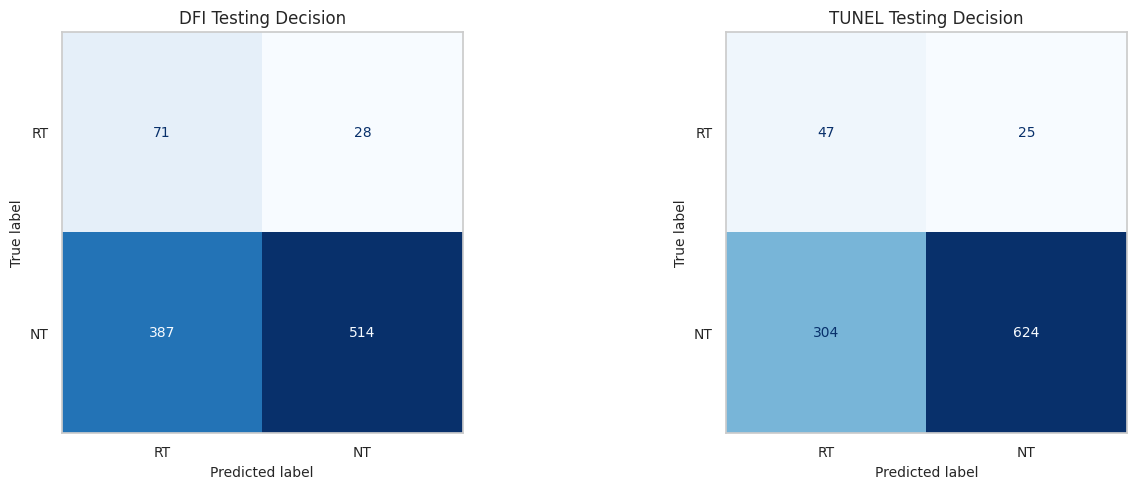

In [ ]:
def evaluate_risk_prediction(y_true1, y_pred1, label1, y_true2, y_pred2, label2):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for ax, y_true, y_pred, label in zip(axes, [y_true1, y_true2], [y_pred1, y_pred2], [label1, label2]):
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)

        print(f"\n--- {label} Risk Classification ---")
        print(f"Accuracy:  {acc:.2%}")
        print(f"Precision: {prec:.2%}")
        print(f"Recall:    {rec:.2%}")
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=["RT", "NT"]))

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["RT", "NT"])
        disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False)
        ax.set_title(f'{label} Testing Decision')
        ax.grid(False)

    plt.tight_layout()
    plt.savefig("confusion_test.png", dpi=400, bbox_inches="tight")
    plt.show()

# --- Call function ---
evaluate_risk_prediction(true_risk_dfi, pred_risk_dfi, "DFI", true_risk_tunel, pred_risk_tunel, "TUNEL")